In [1]:
!dir /astra_data_readonly

20x\ images\ hack.zip  40x_images	      60x_images
20x_images	       60x\ images\ hack.zip  images_40x.zip


In [2]:
# Create directories
!mkdir ../../data
!mkdir ../../data/01_raw
!mkdir ../../data/02_intermediate
!mkdir ../../data/03_training_data/not_normalized
!mkdir ../../data/03_training_data/normalized
!mkdir ../../data/03_training_data/normalized_bias
!mkdir ../../data/04_generated_images

mkdir: cannot create directory ‘../../data’: File exists
mkdir: cannot create directory ‘../../data/01_raw’: File exists
mkdir: cannot create directory ‘../../data/02_intermediate’: File exists
mkdir: cannot create directory ‘../../data/03_training_data/normalized_bias’: File exists


In [3]:
# Copy raw dataset to working directory "data/" directory
!cp -r /astra_data_readonly/*x_images ../../data/01_raw

In [8]:
!ls ../../data/01_raw/20x_images  

AssayPlate_Greiner_#655090_B03_T0001F001L01A01Z01C01.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A02Z01C02.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A03Z01C03.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z01C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z02C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z03C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z04C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z05C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z06C04.tif
AssayPlate_Greiner_#655090_B03_T0001F001L01A04Z07C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A01Z01C01.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A02Z01C02.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A03Z01C03.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z01C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z02C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z03C04.tif
AssayPlate_Greiner_#655090_B03_T0001F002L01A04Z04C04.tif
AssayPlate_Greiner_#655090_B03_

In [23]:
def get_sample_dicts(input_glob_path):

    dataset_samples = glob.glob(input_glob_path)
    print(f"Dataset contains {len(dataset_samples)} .tif files")
    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    #unique_wells = list()
    for sample_dict in dataset_dicts:
        #unique_wells.append(sample_dict["row_col"])
        #magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
        sample_key = (sample_dict["row_col"], sample_dict["field of view"])#, magnification)

        if samples.get(sample_key) is None:
            samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}

        samples[sample_key]["well"] = sample_dict["row_col"]
        print(sample_dict["action_list_number"])
        if sample_dict["action_list_number"] == "A04":# and "input" in sample_dict["path"]: 
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        elif "targets" in sample_dict["path"]:
            # Is a target
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["target"][action_list_number] = sample_dict["path"]
        elif "masks" in sample_dict["path"]:
            # Is a mask
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
        else:
            print("This is not supposed to be reached")
            raise Error()
    samples = list(samples.values())
    return samples, set(unique_wells)

#get_sample_dicts("../../data/03_training_data/normalized_bias/train")

## Separate .tif images into inputs and targets

In [25]:
import sys
sys.path.insert(0, "../../src")


import os
import shutil
import glob
from tqdm import tqdm
from pathlib import Path
import cv2
from utils.utils import get_image_metadata

input_path:str = "../../data/01_raw/"
output_path:str = "../../data/02_intermediate/"
train_ratio=0.8

"""Divide images for the Astra Zeneca competition into training and validation sets.
Group by row_col and field of view
# row_col
# field of view
Input and Target share these common values:
- row_col       = sample id? 
- field of view = amount of zoom
For identifying INPUT:
- action_list_number A04
- imaging_channel    C04
- z_number_3d        Z01 - Z07
For identifying TARGET:
- action_list_number A01 A02 and A03
- imaging_channel    C01, C02, C03
- z_number_3d        Z01
"""
#print(glob.glob(os.path.join(input_path, "*/Assay*")))
#samples, _ = get_sample_dicts(os.path.join(input_path, "*/Assay*"))
dataset_samples = glob.glob(os.path.join(input_path, "*/Assay*"))
print(f"Dataset contains {len(dataset_samples)} .tif files")
dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

# Group all 7 inputs with all 3 respective targets into variable sample
samples = dict()
for sample_dict in dataset_dicts:
    magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
    sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)
    if samples.get(sample_key) is None:
        samples[sample_key] = {"input": dict(), "target": dict()}
    if sample_dict["action_list_number"] == "A04": # or sample_dict["imaging_channel"] == "C04"
        # Is an input
        z_number_3d = sample_dict["z_number_3d"]
        samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
    else:
        # Is an target
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["target"][action_list_number] = sample_dict["path"]
samples = list(samples.values())

print(f"Dataset contains {len(samples)} samples (1 sample = 7 brightfield and 3 fluorescent)")

shutil.rmtree(os.path.join(output_path, "input"))
shutil.rmtree(os.path.join(output_path, "targets"))
Path(os.path.join(output_path, "input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "targets")).mkdir(exist_ok=True, parents=True)
for idx in tqdm(range(len(samples))):
    sample_dict = samples[idx]
    w, h = cv2.imread(sample_dict["input"]["Z01"], -1).shape
    
    magnification = os.path.basename(os.path.dirname(sample_dict["input"]["Z01"]))
    Path(os.path.join(output_path, "input", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, "targets", magnification)).mkdir(exist_ok=True, parents=True)

    for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
        img_path = sample_dict["input"][z_number_3d]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, "input", magnification, filename)
        cv2.imwrite(save_path, img)
        
    for i, action_list_number in enumerate(["A01", "A02", "A03"]):
        img_path = sample_dict["target"][action_list_number]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, "targets", magnification, filename)
        cv2.imwrite(save_path, img)

# 2080 .tif images in Astra Zeneca dataset
# 208 samples (1 sample = 7 brightfield images, 3 flourescent images)

  0%|          | 0/208 [00:00<?, ?it/s]

Dataset contains 2080 .tif files
Dataset contains 208 samples (1 sample = 7 brightfield and 3 fluorescent)


100%|██████████| 208/208 [13:03<00:00,  3.77s/it]


In [27]:
for mag in ["20x_images", "40x_images", "60x_images"]:
    imgs = [os.path.basename(img) for img in glob.glob(f"../../data/02_intermediate/*/{mag}/*")]

    assert len(set(imgs)) == len(imgs)
    print(mag, ":", len(imgs), ".tifs")
    
for mag in ["20x_images", "40x_images", "60x_images"]:
    imgs = [os.path.basename(img) for img in glob.glob(f"../../data/01_raw/{mag}/*")]

    assert len(set(imgs)) == len(imgs)
    print(mag, ":", len(imgs), ".tifs")
       

AssertionError: 

## Create masks for A01 targets (nuclei)

In [55]:
import numpy as np
from skimage import morphology

input_path:str = "../../data/02_intermediate/"
output_path:str = "../../data/02_intermediate/"

def mask(img:np.ndarray) -> np.ndarray:
    """
    Scikit-image's Mask

    Returns:
    mask: scikit-image object (ndarray)
    """
    mask = (img > 2*img.mean()).astype(np.float)
    
    mask = morphology.remove_small_holes(
        morphology.remove_small_objects(
            img > 2*np.mean(img), 500), 500)

    mask = morphology.opening(mask, morphology.disk(3))

    return mask
    
Path(os.path.join(input_path, "masks", "20x_images")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(input_path, "masks", "40x_images")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(input_path, "masks", "60x_images")).mkdir(exist_ok=True, parents=True)
target_images = [path for path in glob.glob(os.path.join(input_path, "targets", "*/*")) if "A01" in path]
for target_path in tqdm(target_images):
    img = cv2.imread(target_path, -1)
    img_mask = mask(img)
    save_path = target_path.replace("/targets/", "/masks/")
    img_mask = img_mask.astype(np.int8)
    success = cv2.imwrite(save_path, img_mask)
    if not success:
        print(f"Could not save {save_path}")

100%|██████████| 208/208 [02:16<00:00,  1.52it/s]


In [29]:
!dir "../../data/02_intermediate"

input  masks  targets


In [ ]:
!dir

In [50]:
import os
import glob

import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm


input_path:str = "../../data/02_intermediate/"

stats = dict()
for mag_path in tqdm(glob.glob(os.path.join(input_path, "input", "*"))):
    magnification = os.path.basename(mag_path)
 
    stats[magnification] = dict()
    stats[magnification]["mean"] = list()
    stats[magnification]["std"] = list()
    stats[magnification]["max"] = list()
    stats[magnification]["min"] = list()
    
    img_paths = glob.glob(os.path.join(mag_path, "*"))
    
    for img_path in tqdm(img_paths):
        img = cv2.imread(img_path, -1)

        stats[magnification]["mean"].append(img.mean())
        stats[magnification]["std"].append(img.std())
        stats[magnification]["max"].append(img.max())
        stats[magnification]["min"].append(img.min())


 46%|████▌     | 155/336 [00:18<00:21,  8.42it/s]


 92%|█████████▏| 309/336 [00:36<00:03,  8.43it/s]


 28%|██▊       | 127/448 [00:13<00:35,  9.07it/s]


 63%|██████▎   | 281/448 [00:30<00:17,  9.46it/s]


 97%|█████████▋| 435/448 [00:46<00:01,  9.38it/s]


 21%|██        | 142/672 [00:14<00:54,  9.69it/s]


 44%|████▍     | 297/672 [00:30<00:39,  9.40it/s]


 67%|██████▋   | 451/672 [00:47<00:23,  9.39it/s]


 90%|█████████ | 605/672 [01:03<00:07,  9.15it/s]


100%|██████████| 3/3 [02:38<00:00, 52.84s/it]


In [51]:
for m in stats:
    print(m)
    print("mean", np.mean(stats[m]["mean"]))
    print("std", np.sqrt(np.mean(np.array(stats[m]["std"])**2)))
    print("max", np.max(stats[m]["max"]))
    print("min", np.min(stats[m]["min"]))
    print()

20x_images
mean 2594.456944817624
std 966.056444447595
max 19788
min 109

40x_images
mean 713.3602562979694
std 282.06724399901475
max 5900
min 1

60x_images
mean 524.9695709548554
std 228.20462393791905
max 4796
min 0



In [52]:
import pandas as pd
output_path:str = "../../data/06_outputs/"
!mkdir "../../data/06_outputs/"
Path(output_path).mkdir(exist_ok=True, parents=True)

df = pd.DataFrame(columns=["mean", "std", "max", "min"])
for m in stats:
    df.loc[m] = pd.Series({
        "mean": np.mean(stats[m]["mean"]),
        "std":  np.sqrt(np.mean(np.array(stats[m]["std"])**2)),
        "max":  np.max(stats[m]["max"]),
        "min":  np.min(stats[m]["min"])
    })
    
df.loc["global"] = pd.Series({
    "mean": np.mean(stats["20x_images"]["mean"] + stats["40x_images"]["mean"] + stats["60x_images"]["mean"]),
    "std":  np.sqrt(np.mean(np.array(stats["20x_images"]["std"] + stats["40x_images"]["std"] + stats["60x_images"]["std"])**2)),
    "max":  np.max(stats["20x_images"]["max"] + stats["40x_images"]["max"] + stats["60x_images"]["max"]),
    "min":  np.min(stats["20x_images"]["min"] + stats["40x_images"]["min"] + stats["60x_images"]["min"])
})
print(df)
df.to_csv(os.path.join(output_path, "input_statistics.csv"))

mkdir: cannot create directory ‘../../data/06_outputs/’: File exists
                   mean         std      max    min
20x_images  2594.456945  966.056444  19788.0  109.0
40x_images   713.360256  282.067244   5900.0    1.0
60x_images   524.969571  228.204624   4796.0    0.0
global      1060.509945  513.697530  19788.0    0.0


In [34]:
pd.read_csv(os.path.join(output_path, "input_statistics.csv")).head()

,Unnamed: 0,mean,std,max,min
0,20x_images,2594.456945,966.056444,19788.0,109.0
1,40x_images,713.360256,282.067244,5900.0,1.0
2,60x_images,524.969571,228.204624,4796.0,0.0


# Split data into train and validation data

In [59]:
## Normalize inputs and move to 03_training_data
# Move targets and masks to 03_training_data
!dir ../../data/03_training_data

In [83]:
import os
import shutil
import glob
from tqdm import tqdm
from pathlib import Path
import cv2
from utils.utils import get_image_metadata

input_path:str = "../../data/02_intermediate/"
output_path:str = "../../data/03_training_data/"

train_wells = ["D02", "D03", "D04", "C02", "C03", "C04"]
valid_wells = ["B03", "B04"]


"""Divide images for the Astra Zeneca competition into training and validation sets.
Group by row_col and field of view
# row_col
# field of view
Input and Target share these common values:
- row_col       = sample id? 
- field of view = amount of zoom
For identifying INPUT:
- action_list_number A04
- imaging_channel    C04
- z_number_3d        Z01 - Z07
For identifying TARGET:
- action_list_number A01 A02 and A03
- imaging_channel    C01, C02, C03
- z_number_3d        Z01
"""

samples, unique_row_col = get_sample_dicts(input_path)
#dataset_samples = glob.glob(os.path.join(input_path, "*/*/Assay*"))
#print(f"Dataset contains {len(dataset_samples)} .tif files")
#dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
#
## Group all 7 inputs with all 3 respective targets into variable sample
#samples = dict()
#unique_wells = list()
#for sample_dict in dataset_dicts:
#    unique_wells.append(sample_dict["row_col"])
#    magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
#    sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)
#    
#    if samples.get(sample_key) is None:
#        samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}
#        
#    samples[sample_key]["well"] = sample_dict["row_col"]
#    
#    if sample_dict["action_list_number"] == "A04" and "input" in sample_dict["path"]: 
#        # Is an input
#        z_number_3d = sample_dict["z_number_3d"]
#        samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
#    elif "targets" in sample_dict["path"]:
#        # Is a target
#        action_list_number = sample_dict["action_list_number"]
#        samples[sample_key]["target"][action_list_number] = sample_dict["path"]
#    elif "masks" in sample_dict["path"]:
#        # Is a mask
#        action_list_number = sample_dict["action_list_number"]
#        samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
#    else:
#        print("This is not supposed to be reached")
#        raise Error()
#samples = list(samples.values())

print(f"Dataset contains {len(samples)} samples (1 sample = 7 brightfield and 3 fluorescent)")
print("All wells:", set(unique_row_col))

#shutil.rmtree(os.path.join(output_path, "train/input"))
#shutil.rmtree(os.path.join(output_path, "valid/input"))
#shutil.rmtree(os.path.join(output_path, "train/targets"))
#shutil.rmtree(os.path.join(output_path, "valid/targets"))
Path(os.path.join(output_path, "train/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "train/targets")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/targets")).mkdir(exist_ok=True, parents=True)

for idx in tqdm(range(len(samples))):
    sample_dict = samples[idx]

    if sample_dict["well"] in train_wells:
        _set = "train"
    elif sample_dict["well"] in valid_wells:
        _set = "valid"
    else:
        assert False # This is not supposed to be reached
    
    magnification = os.path.basename(os.path.dirname(sample_dict["input"]["Z01"]))
    Path(os.path.join(output_path, _set, "input", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "targets", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "masks", magnification)).mkdir(exist_ok=True, parents=True)

    for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
        img_path = sample_dict["input"][z_number_3d]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "input", magnification, filename)
        cv2.imwrite(save_path, img)
        
    for i, action_list_number in enumerate(["A01", "A02", "A03"]):
        img_path = sample_dict["target"][action_list_number]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "targets", magnification, filename)
        cv2.imwrite(save_path, img)
        
    img_path = sample_dict["mask"]["A01"]
    img = cv2.imread(img_path, -1)
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_path, _set, "masks", magnification, filename)
    cv2.imwrite(save_path, img)
    
# 2080 .tif images in Astra Zeneca dataset
# 208 samples (1 sample = 7 brightfield images, 3 flourescent images)




















  0%|          | 0/208 [00:00<?, ?it/s]

Dataset contains 2288 .tif files
Dataset contains 208 samples (1 sample = 7 brightfield and 3 fluorescent)
All wells: {'D04', 'B03', 'D02', 'C02', 'B04', 'C03', 'C04', 'D03'}




















  0%|          | 1/208 [00:02<09:33,  2.77s/it]

















  1%|          | 2/208 [00:05<09:29,  2.76s/it]

















  1%|▏         | 3/208 [00:08<09:25,  2.76s/it]

















  2%|▏         | 4/208 [00:11<09:21,  2.75s/it]

















  2%|▏         | 5/208 [00:13<09:21,  2.77s/it]

















  3%|▎         | 6/208 [00:16<09:16,  2.76s/it]

















  3%|▎         | 7/208 [00:19<09:14,  2.76s/it]

















  4%|▍         | 8/208 [00:22<09:14,  2.77s/it]

















  4%|▍         | 9/208 [00:24<09:10,  2.77s/it]

















  5%|▍         | 10/208 [00:27<09:04,  2.75s/it]

















  5%|▌         | 11/208 [00:30<09:05,  2.77s/it]

















  6%|▌         | 12/208 [00:33<09:01,  2.76s/it]

















  6%|▋         | 13/208 [00:35<09:01,  2.77s/it]

















  7%|▋         | 14/208 [00:38<08:55,  2.76s/it]

















  7%|▋         | 15/208 [00:41<08:54,  2.77s/it]

















 

 66%|██████▌   | 137/208 [05:42<02:49,  2.39s/it]

















 66%|██████▋   | 138/208 [05:44<02:47,  2.39s/it]

















 67%|██████▋   | 139/208 [05:46<02:43,  2.37s/it]

















 67%|██████▋   | 140/208 [05:49<02:39,  2.35s/it]

















 68%|██████▊   | 141/208 [05:51<02:37,  2.34s/it]

















 68%|██████▊   | 142/208 [05:53<02:34,  2.34s/it]

















 69%|██████▉   | 143/208 [05:56<02:31,  2.33s/it]

















 69%|██████▉   | 144/208 [05:58<02:29,  2.34s/it]

















 70%|██████▉   | 145/208 [06:00<02:28,  2.35s/it]

















 70%|███████   | 146/208 [06:03<02:26,  2.36s/it]

















 71%|███████   | 147/208 [06:05<02:23,  2.36s/it]

















 71%|███████   | 148/208 [06:08<02:21,  2.36s/it]

















 72%|███████▏  | 149/208 [06:10<02:18,  2.35s/it]

















 72%|███████▏  | 150/208 [06:12<02:17,  2.37s/it]

















 73%|███████▎  | 151/208 [06:14<02:13,  2.34s/it]














## Normalized with regards to magnification

In [56]:
import sys
sys.path.insert(0, "../../src")

import os
import shutil
import glob
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import cv2
from utils.utils import get_image_metadata

input_path:str = "../../data/02_intermediate/"
output_path:str = "../../data/03_training_data/normalized_bias"

train_wells = ["D02", "D03", "D04", "C02", "C03", "C04"]
valid_wells = ["B03", "B04"]


stats = pd.read_csv("../../data/06_outputs/input_statistics.csv")
stats = stats.rename(columns={"Unnamed: 0": "row"}).set_index("row")
#stats.loc["20x_images"]

"""Divide images for the Astra Zeneca competition into training and validation sets.
Group by row_col and field of view
# row_col
# field of view
Input and Target share these common values:
- row_col       = sample id? 
- field of view = amount of zoom
For identifying INPUT:
- action_list_number A04
- imaging_channel    C04
- z_number_3d        Z01 - Z07
For identifying TARGET:
- action_list_number A01 A02 and A03
- imaging_channel    C01, C02, C03
- z_number_3d        Z01
"""

#samples, unique_wells = get_sample_dicts(input_path)

dataset_samples = glob.glob(os.path.join(input_path, "*/*/Assay*"))
print(f"Dataset contains {len(dataset_samples)} .tif files")
dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
samples = dict()
# Group all 7 inputs with all 3 respective targets into variable sample
samples = dict()
unique_wells = list()
for sample_dict in dataset_dicts:
    unique_wells.append(sample_dict["row_col"])
    magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
    sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)
    
    if samples.get(sample_key) is None:
        samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}
        
    samples[sample_key]["well"] = sample_dict["row_col"]
    
    if sample_dict["action_list_number"] == "A04" and "input" in sample_dict["path"]: 
        # Is an input
        z_number_3d = sample_dict["z_number_3d"]
        samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
    elif "targets" in sample_dict["path"]:
        # Is a target
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["target"][action_list_number] = sample_dict["path"]
    elif "masks" in sample_dict["path"]:
        # Is a mask
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
    else:
        print("This is not supposed to be reached")
        raise Error()
samples = list(samples.values())

print(f"Dataset contains {len(samples)} samples (1 sample = 7 brightfield and 3 fluorescent)")
print("All wells:", set(unique_wells))

#shutil.rmtree(os.path.join(output_path, "train/input"))
#shutil.rmtree(os.path.join(output_path, "valid/input"))
#shutil.rmtree(os.path.join(output_path, "train/targets"))
#shutil.rmtree(os.path.join(output_path, "valid/targets"))
Path(os.path.join(output_path, "train/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "train/targets")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/targets")).mkdir(exist_ok=True, parents=True)

for idx in tqdm(range(len(samples))):
    sample_dict = samples[idx]

    if sample_dict["well"] in train_wells:
        _set = "train"
    elif sample_dict["well"] in valid_wells:
        _set = "valid"
    else:
        assert False # This is not supposed to be reached
    
    magnification = os.path.basename(os.path.dirname(sample_dict["input"]["Z01"]))
    Path(os.path.join(output_path, _set, "input", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "targets", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "masks", magnification)).mkdir(exist_ok=True, parents=True)

    for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
        img_path = sample_dict["input"][z_number_3d]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "input", magnification, filename)
        #print(img.mean())
        img=(img - stats.loc[magnification]["mean"])/stats.loc[magnification]["std"]
        #print(img.mean())
        cv2.imwrite(save_path, img)
        
    for i, action_list_number in enumerate(["A01", "A02", "A03"]):
        img_path = sample_dict["target"][action_list_number]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "targets", magnification, filename)
        cv2.imwrite(save_path, img)
        
    img_path = sample_dict["mask"]["A01"]
    img = cv2.imread(img_path, -1)
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_path, _set, "masks", magnification, filename)
    cv2.imwrite(save_path, img)
    
# 2080 .tif images in Astra Zeneca dataset
# 208 samples (1 sample = 7 brightfield images, 3 flourescent images)


  0%|          | 0/208 [00:00<?, ?it/s]

Dataset contains 2288 .tif files
Dataset contains 208 samples (1 sample = 7 brightfield and 3 fluorescent)
All wells: {'C03', 'D03', 'D02', 'C02', 'C04', 'D04', 'B04', 'B03'}


100%|██████████| 208/208 [06:46<00:00,  1.96s/it]


## Normalized global

In [57]:
import sys
sys.path.insert(0, "../../src")

import os
import shutil
import glob
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import cv2
from utils.utils import get_image_metadata

input_path:str = "../../data/02_intermediate/"
output_path:str = "../../data/03_training_data/normalized"

train_wells = ["D02", "D03", "D04", "C02", "C03", "C04"]
valid_wells = ["B03", "B04"]


stats = pd.read_csv("../../data/06_outputs/input_statistics.csv")
stats = stats.rename(columns={"Unnamed: 0": "row"}).set_index("row")
#stats.loc["20x_images"]

"""Divide images for the Astra Zeneca competition into training and validation sets.
Group by row_col and field of view
# row_col
# field of view
Input and Target share these common values:
- row_col       = sample id? 
- field of view = amount of zoom
For identifying INPUT:
- action_list_number A04
- imaging_channel    C04
- z_number_3d        Z01 - Z07
For identifying TARGET:
- action_list_number A01 A02 and A03
- imaging_channel    C01, C02, C03
- z_number_3d        Z01
"""

#samples, unique_wells = get_sample_dicts(input_path)

dataset_samples = glob.glob(os.path.join(input_path, "*/*/Assay*"))
print(f"Dataset contains {len(dataset_samples)} .tif files")
dataset_dicts = [get_image_metadata(path) for path in dataset_samples]
samples = dict()
# Group all 7 inputs with all 3 respective targets into variable sample
samples = dict()
unique_wells = list()
for sample_dict in dataset_dicts:
    unique_wells.append(sample_dict["row_col"])
    magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
    sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)
    
    if samples.get(sample_key) is None:
        samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}
        
    samples[sample_key]["well"] = sample_dict["row_col"]
    
    if sample_dict["action_list_number"] == "A04" and "input" in sample_dict["path"]: 
        # Is an input
        z_number_3d = sample_dict["z_number_3d"]
        samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
    elif "targets" in sample_dict["path"]:
        # Is a target
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["target"][action_list_number] = sample_dict["path"]
    elif "masks" in sample_dict["path"]:
        # Is a mask
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
    else:
        print("This is not supposed to be reached")
        raise Error()
samples = list(samples.values())

print(f"Dataset contains {len(samples)} samples (1 sample = 7 brightfield and 3 fluorescent)")
print("All wells:", set(unique_wells))

#shutil.rmtree(os.path.join(output_path, "train/input"))
#shutil.rmtree(os.path.join(output_path, "valid/input"))
#shutil.rmtree(os.path.join(output_path, "train/targets"))
#shutil.rmtree(os.path.join(output_path, "valid/targets"))
Path(os.path.join(output_path, "train/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "train/targets")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/input")).mkdir(exist_ok=True, parents=True)
Path(os.path.join(output_path, "valid/targets")).mkdir(exist_ok=True, parents=True)

for idx in tqdm(range(len(samples))):
    sample_dict = samples[idx]

    if sample_dict["well"] in train_wells:
        _set = "train"
    elif sample_dict["well"] in valid_wells:
        _set = "valid"
    else:
        assert False # This is not supposed to be reached
    
    magnification = os.path.basename(os.path.dirname(sample_dict["input"]["Z01"]))
    Path(os.path.join(output_path, _set, "input", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "targets", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "masks", magnification)).mkdir(exist_ok=True, parents=True)

    for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
        img_path = sample_dict["input"][z_number_3d]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "input", magnification, filename)
        #print(img.mean())
        img=(img - stats.loc["global"]["mean"])/stats.loc["global"]["std"]
        #print(img.mean())
        cv2.imwrite(save_path, img)
        
    for i, action_list_number in enumerate(["A01", "A02", "A03"]):
        img_path = sample_dict["target"][action_list_number]
        img = cv2.imread(img_path, -1)
        filename = os.path.basename(img_path)
        save_path = os.path.join(output_path, _set, "targets", magnification, filename)
        cv2.imwrite(save_path, img)
        
    img_path = sample_dict["mask"]["A01"]
    img = cv2.imread(img_path, -1)
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_path, _set, "masks", magnification, filename)
    cv2.imwrite(save_path, img)
    
# 2080 .tif images in Astra Zeneca dataset
# 208 samples (1 sample = 7 brightfield images, 3 flourescent images)


  0%|          | 0/208 [00:00<?, ?it/s]

Dataset contains 2288 .tif files
Dataset contains 208 samples (1 sample = 7 brightfield and 3 fluorescent)
All wells: {'C03', 'D03', 'D02', 'C02', 'C04', 'D04', 'B04', 'B03'}


100%|██████████| 208/208 [06:46<00:00,  1.96s/it]


## Debugging

  0%|          | 0/156 [00:00<?, ?it/s]

Dataset contains 1716 .tif files
Dataset contains 156 samples (1 sample = 7 brightfield and 3 fluorescent)
All wells: {'C03', 'D03', 'C02', 'C04', 'D04', 'D02'}


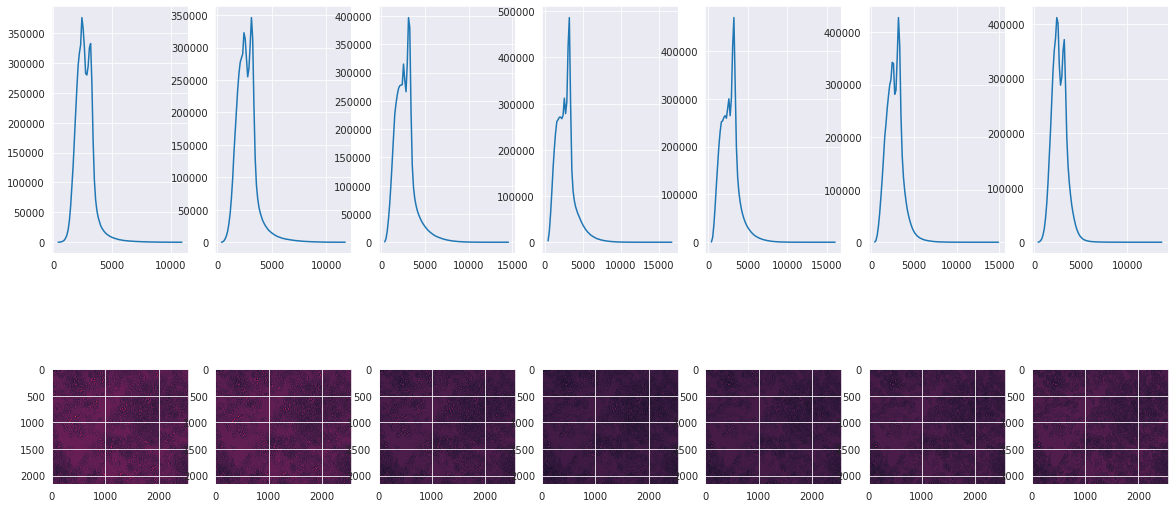

  0%|          | 0/156 [00:06<?, ?it/s]


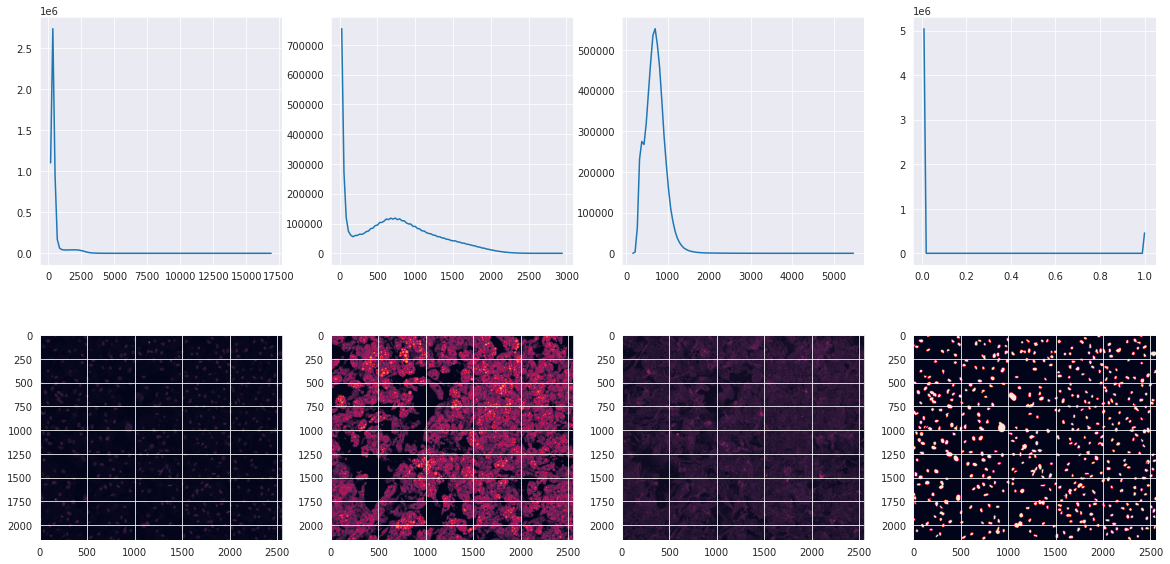

In [47]:
import sys
sys.path.insert(0, "../../src")

import os
import shutil
import glob
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from utils.utils import get_image_metadata
sns.set_style("darkgrid")

input_path:str = "../../data/03_training_data/train"

"""Divide images for the Astra Zeneca competition into training and validation sets.
Group by row_col and field of view
# row_col
# field of view
Input and Target share these common values:
- row_col       = sample id? 
- field of view = amount of zoom
For identifying INPUT:
- action_list_number A04
- imaging_channel    C04
- z_number_3d        Z01 - Z07
For identifying TARGET:
- action_list_number A01 A02 and A03
- imaging_channel    C01, C02, C03
- z_number_3d        Z01
"""

#samples, unique_wells = get_sample_dicts(input_path)
dataset_samples = glob.glob(os.path.join(input_path, "*/*/Assay*"))
print(f"Dataset contains {len(dataset_samples)} .tif files")
dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

# Group all 7 inputs with all 3 respective targets into variable sample
samples = dict()
unique_wells = list()
for sample_dict in dataset_dicts:
    unique_wells.append(sample_dict["row_col"])
    magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
    sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)
    
    if samples.get(sample_key) is None:
        samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}
        
    samples[sample_key]["well"] = sample_dict["row_col"]
    
    if sample_dict["action_list_number"] == "A04" and "input" in sample_dict["path"]: 
        # Is an input
        z_number_3d = sample_dict["z_number_3d"]
        samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
    elif "targets" in sample_dict["path"]:
        # Is a target
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["target"][action_list_number] = sample_dict["path"]
    elif "masks" in sample_dict["path"]:
        # Is a mask
        action_list_number = sample_dict["action_list_number"]
        samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
    else:
        print("This is not supposed to be reached")
        raise Error()
samples = list(samples.values())

print(f"Dataset contains {len(samples)} samples (1 sample = 7 brightfield and 3 fluorescent)")
print("All wells:", set(unique_wells))


for idx in tqdm(range(len(samples))):
    sample_dict = samples[idx]

    if sample_dict["well"] in train_wells:
        _set = "train"
    elif sample_dict["well"] in valid_wells:
        _set = "valid"
    else:
        assert False # This is not supposed to be reached
    
    magnification = os.path.basename(os.path.dirname(sample_dict["input"]["Z01"]))
    Path(os.path.join(output_path, _set, "input", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "targets", magnification)).mkdir(exist_ok=True, parents=True)
    Path(os.path.join(output_path, _set, "masks", magnification)).mkdir(exist_ok=True, parents=True)

    _, axs = plt.subplots(2,7, figsize=(20,10))
    for i, z_number_3d in enumerate(["Z01", "Z02", "Z03", "Z04", "Z05", "Z06", "Z07"]):
        img_path = sample_dict["input"][z_number_3d]
        img = cv2.imread(img_path, -1)
        axs[1,i].imshow(img)
        #print(img.dtype)
        axs[0,i].plot(np.histogram(img, bins=100)[1][1:], np.histogram(img, bins=100)[0])
        #plt.show()
        
    plt.show()
    _, axs = plt.subplots(2,4, figsize=(20,10))
    for i, action_list_number in enumerate(["A01", "A02", "A03"]):
        img_path = sample_dict["target"][action_list_number]
        img = cv2.imread(img_path, -1)
        
        axs[1,i].imshow(img)
        #print(img.dtype)
        axs[0,i].plot(np.histogram(img, bins=100)[1][1:], np.histogram(img, bins=100)[0])
        #plt.show()
        

    img_path = sample_dict["mask"]["A01"]
    img = cv2.imread(img_path, -1)
    axs[1,3].imshow(img)
    axs[0,3].plot(np.histogram(img, bins=100)[1][1:], np.histogram(img, bins=100)[0])
    break


In [31]:
def get_sample_dicts(input_path):

    dataset_samples = glob.glob(os.path.join(input_path, "*/*/Assay*"))
    print(f"Dataset contains {len(dataset_samples)} .tif files")
    dataset_dicts = [get_image_metadata(path) for path in dataset_samples]

    # Group all 7 inputs with all 3 respective targets into variable sample
    samples = dict()
    unique_wells = list()
    for sample_dict in dataset_dicts:
        unique_wells.append(sample_dict["row_col"])
        magnification = os.path.basename(os.path.dirname(sample_dict["path"]))
        sample_key = (sample_dict["row_col"], sample_dict["field of view"], magnification)

        if samples.get(sample_key) is None:
            samples[sample_key] = {"input": dict(), "target": dict(), "mask": dict(), "well": None}

        samples[sample_key]["well"] = sample_dict["row_col"]

        if sample_dict["action_list_number"] == "A04" and "input" in sample_dict["path"]: 
            # Is an input
            z_number_3d = sample_dict["z_number_3d"]
            samples[sample_key]["input"][z_number_3d] = sample_dict["path"]
        elif "targets" in sample_dict["path"]:
            # Is a target
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["target"][action_list_number] = sample_dict["path"]
        elif "masks" in sample_dict["path"]:
            # Is a mask
            action_list_number = sample_dict["action_list_number"]
            samples[sample_key]["mask"][action_list_number] = sample_dict["path"]
        else:
            print("This is not supposed to be reached")
            raise Error()
    samples = list(samples.values())
    return samples, set(unique_wells)

get_sample_dicts("../../data/03_training_data/normalized_bias/train")

Dataset contains 1716 .tif files


{'C02', 'C03', 'C04', 'D02', 'D03', 'D04'}

In [22]:
!pip install seaborn

     |████████████████████████████████| 283 kB 3.2 MB/s eta 0:00:01


In [ ]:
# Model 1 best val score: 121.04